In [9]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from tqdm.notebook import trange
import time
import itertools

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.3.5
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Data generator

### Data generator Hawkes process (constant baseline).

In [203]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 2
generator_par = {'trial_length': trial_length, 'trial_window':[0, trial_length], 'num_trials': 500, 'random_seed': None,
        'type': 'square', 'mu': [20., 20.], 'alpha': [[0., 2], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + f'Hawkes_square_alpha2_beta40ms_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(1), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_hawkes_spike_times(generator_par, verbose=0)
#     generator.spike_times_statistics(spike_times, generator_par['trial_length'], verbose=0)
    file_path = data_dir + f'Hawkes_square_alpha2_beta40ms_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.10s/it]


### Data generator Amarasingham (fixed number of baseline clusters) + coupling filter.

In [9]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 2
trial_window = [0, trial_length]
num_trials = 2000
alpha = -1
alpha_str = 'N1'
model_name = f'amarasingham_square_alpha{alpha_str}_beta40ms_trials{num_trials}'
generator_par = {'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'num_trials': num_trials, 'baseline': 10, 'sigma': 0.04, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 300), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times(generator_par, verbose=0)
#     generator.spike_times_statistics(spike_times, generator_par['trial_length'], verbose=0)
#     _=generator.plot_psth(spike_times, generator_par['trial_length'], 0.005, ylim=[0, 100])
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/amarasingham_square_alphaN1_beta40ms_trials2000_generator_par.pkl
100%|█████████████████████████████████████████████████████████| 300/300 [10:10:07<00:00, 122.03s/it]


### Amarasingham non-repeated trials (fixed number of baseline clusters) + coupling filter.

In [21]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 2
trial_window = [0, trial_length]
num_trials = 2000
alpha = -1
alpha_str = 'N1'
model_name = f'amarasingham_square_alpha{alpha_str}_beta40ms_trials{num_trials}_nonrepeated'
generator_par = {'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'num_trials': num_trials, 'baseline': 10, 'sigma': 0.04, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 300), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/amarasingham_square_alphaN1_beta40ms_trials2000_nonrepeated_generator_par.pkl
100%|█████████████████████████████████████████████████████████| 300/300 [10:50:57<00:00, 130.19s/it]


### Basic: Linear Cox (baseline clusters from Poisson) + Gaussian window + non-repeated trials + coupling filter.
For the coupling matrix, alpha, beta has format [[Target->Target, Source->Target], [Target->Source, Source->Source]]

In [ ]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_sigma100ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 100), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

### Double coupling Linear Cox (baseline clusters from Poisson) + Gaussian window + non-repeated trials + coupling filter.

In [6]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'Source2Target_alpha{alpha_str}_beta{beta_str}ms_Target2Source_alpha01_sigma100ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.1, 0.0]], 'beta': [[1.0, beta/1000], [beta/1000, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 100), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_Source2Target_alpha2_beta30ms_Target2Source_alpha01_sigma100ms_trials200_nonrepeated_generator_par.pkl
100%|█████████████████████████████████████████████████████████████| 100/100 [46:53<00:00, 28.14s/it]


### Self-coupling Linear Cox (baseline clusters from Poisson) + Gaussian window + non-repeated trials + coupling filter

In [123]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_selfcoupling_sourceN15_10ms_targetN20_20ms_sigma100ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 20, 'mu': 20, 'baseline': 20, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None,
    'type': 'square', 'alpha': [[-20.0, alpha], [0.0, -15.0]], 'beta': [[0.02, beta/1000], [0.0, 0.01]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 20), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_alpha2_beta30ms_selfcoupling_sourceN15_10ms_targetN20_20ms_sigma100ms_trials200_nonrepeated_generator_par.pkl
100%|███████████████████████████████████████████████████████████████| 20/20 [09:30<00:00, 28.55s/it]


### Laplace window + Linear Cox process

In [89]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
model_name = 'poisson_background_laplacian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_sigma100ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'laplacian', 'sigma': 0.1, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 100), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_laplacian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_generator_par.pkl
100%|███████████████████████████████████████████████████████████| 100/100 [1:21:38<00:00, 48.98s/it]


### For hypothesis testing.

In [52]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 10
alpha = 1; alpha_str = '1'
beta = 30; beta_str = '30'  # ms
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_sigma100ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 100), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_alpha1_beta30ms_sigma100ms_trials10_nonrepeated_generator_par.pkl
100%|█████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


### Fast changing Linear Cox + Gaussian window + non-repeated trials + coupling filter.

In [3]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
# model_name = 'poisson_background_gaussian_mixture_square_' + \
#         f'alpha{alpha_str}_beta{beta_str}ms_sigma20ms_trials{num_trials}_nonrepeated'
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_sigma8ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.008, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 100), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma8ms_trials200_nonrepeated_generator_par.pkl
100%|███████████████████████████████████████████████████████████| 100/100 [1:39:18<00:00, 59.59s/it]


In [98]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
# model_name = 'poisson_background_gaussian_mixture_square_' + \
#         f'alpha{alpha_str}_beta{beta_str}ms_sigma20ms_trials{num_trials}_nonrepeated'
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_sigma5ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.005, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 25), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma5ms_trials200_nonrepeated_generator_par.pkl
100%|██████████████████████████████████████████████████████████████| 25/25 [42:55<00:00, 103.01s/it]


###  Varying Gaussian window + Lienear Cox + non-repeated trials + coupling filter.

In [14]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_varying_sigma_80_140ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian_varying', 'sigma': [0.08, 0.14], 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 300), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_alpha2_beta30ms_varying_sigma_80_140ms_trials200_nonrepeated_generator_par.pkl
100%|███████████████████████████████████████████████████████████| 300/300 [2:14:05<00:00, 26.82s/it]


### Injection non-shared + Linear Cox + non-repeated trials + coupling filter.

In [ ]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_sigma_100ms_sharerho20_nonsharerho10_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 20, 'mu': 20, 'rho_injection': 10, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(148, 300), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_inject_nonshared_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

### Inhomo-injection non-shared + Linear Cox + non-repeated trials + coupling filter.

i (id=2 here, as source) is constant baseline, j (target) is fluctuating

In [6]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_sigma_100ms_inhomorho_10_0_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 0, 'mu': 0, 'rho_injection': [10, 0], 'baseline': 20, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(20, 50), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_inhomo_inject_nonshared_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_10_0_trials200_nonrepeated_generator_par.pkl
100%|███████████████████████████████████████████████████████████████| 30/30 [09:36<00:00, 19.21s/it]


h (id=0 here, as target) is constant baseline, i (source) is fluctuating

In [7]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_sigma_100ms_inhomorho_target0_source10_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 0, 'mu': 0, 'rho_injection': [10, 0], 'baseline': 20, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 50), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_inhomo_inject_nonshared_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_target0_source10_trials200_nonrepeated_generator_par.pkl
100%|███████████████████████████████████████████████████████████████| 50/50 [18:12<00:00, 21.85s/it]


### Delayed shared + Linear Cox + non-repeated trials + coupling filter.

In [9]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_sigma_100ms_delaysN20ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'delays': [0.0, 0.02], 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 20), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_delayed_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delaysN20ms_trials200_nonrepeated_generator_par.pkl
100%|███████████████████████████████████████████████████████████████| 20/20 [14:59<00:00, 44.99s/it]


### Sinusoid + linear Cox

In [17]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
amplitude = 5

for lag in np.arange(0,8):
    model_name = 'poisson_background_gaussian_mixture_square_' + \
            f'alpha{alpha_str}_beta{beta_str}ms_sigma_100ms_sinusoid_amp{amplitude}_delay{lag}div64_trials{num_trials}_nonrepeated'
    print(model_name)

    generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
        'baseline': 30, 'amplitude': amplitude, 'frequency': 1, 'window': 'sinusoid', 'delays': [0.0, lag/64], 'random_seed': None,
        'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
    file_path = data_dir + model_name + '_generator_par.pkl'
    util.save_variable(file_path, generator_par)

    for itr in tqdm(range(0, 100), ncols=100, file=sys.stdout):
        generator_par['random_seed'] = itr
        init_lag = np.random.rand()
        generator_par['delays'][0] = generator_par['delays'][0] + init_lag
        generator_par['delays'][1] = generator_par['delays'][1] + init_lag
        spike_times = generator.generate_linear_cox_coupling_filter_spike_times_delayed_sinusoid(generator_par, verbose=0)
        file_path = data_dir + model_name + f'_itr{itr}.pkl'
        util.save_variable(file_path, spike_times, verbose=False)

poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay0div64_trials200
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay0div64_trials200_generator_par.pkl
100%|█████████████████████████████████████████████████████████████| 100/100 [42:32<00:00, 25.52s/it]
poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay1div64_trials200
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay1div64_trials200_generator_par.pkl
100%|█████████████████████████████████████████████████████████████| 100/100 [41:02<00:00, 24.63s/it]
poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay2div64_trials200
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_backgro

### Full model bivariate

In [10]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
beta = 30; beta_str = '30'  # ms
model_name = f'poisson_background_gaussian_mixture_square_full_model_beta{beta_str}ms_sigma100ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None,
    'type': 'square', 'alpha': [[0.5, -2.0], [2.0, 0.5]], 'beta': [[beta/1000, beta/1000], [beta/1000, beta/1000]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 25), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_full_model_beta30ms_sigma100ms_trials200_nonrepeated_generator_par.pkl
100%|███████████████████████████████████████████████████████████████| 25/25 [13:11<00:00, 31.67s/it]


### Multivariate slow background + strong spike driver

In [ ]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
# Inject spike trains. (can introduce coupling effects)
alpha = np.zeros([6,6]); alpha[-1,:4] = 15; alpha[-2,:4] = 15
beta = np.zeros([6,6]); beta[-1,:4] = 0.01; beta[-2,:4] = 0.01

model_name = 'poisson_background_gaussian_mixture_square_spike_driver' + \
        f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'

generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 20, 'mu':20, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 1, 
    'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)

file_path = data_dir + model_name + f'_itr{itr}.pkl'
util.save_variable(file_path, spike_times, verbose=False)

### Multivariate only spike driver.

In [ ]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
# Inject spike trains. (can introduce coupling effects)
alpha = np.zeros([6,6]); alpha[-1,:4] = 15; alpha[-2,:4] = 15
beta = np.zeros([6,6]); beta[-1,:4] = 0.01; beta[-2,:4] = 0.01

model_name = 'nobackground_square_spike_driver' + \
        f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'

generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 0, 'mu':0, 'baseline': 20, 'window': 'gaussian', 'sigma': 1, 'random_seed': 2, 
    'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)

file_path = data_dir + model_name + f'_itr{itr}.pkl'
util.save_variable(file_path, spike_times, verbose=False)

### Multivariate point processes
alpha[target, [source1, source2,...]]

In [12]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/multivariate_coupling_data/'
trial_length = 5
num_nodes = 6
trial_window = [0, trial_length]
num_trials = 200
alpha = np.zeros([num_nodes,num_nodes]); alpha[5,[0,1,2,3]] = -2; alpha[4,[0,1,2,3]] = 2; #alpha[6,[7,9]]=2
beta = np.zeros([num_nodes,num_nodes]) + 0.03;
model_name = f'poisson_background_gaussian_mixture_multivariate_nodes{alpha.shape[0]}_sigma_100ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 20, 'mu':20, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None, 
    'type': 'square', 'num_nodes': num_nodes, 'alpha': alpha, 'beta': beta}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(0, 20), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=0)
    file_path = data_dir + model_name + f'_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/multivariate_coupling_data/poisson_background_gaussian_mixture_multivariate_nodes6_sigma_100ms_trials200_nonrepeated_generator_par.pkl
100%|████████████████████████████████████████████████████████████| 20/20 [1:36:02<00:00, 288.13s/it]


# Model fitting

### General fitting.

In [8]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'

# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alphaN2_beta30ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_varying_sigma_80_140ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_sharerho20_nonsharerho10_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma20ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma5ms_trials200_nonrepeated'
# model_name = 'poisson_background_laplacian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_self_coupling_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_self_coupling15ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_self_coupling15ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN15_10ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_target_selfcouplingN20_20ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN20_20ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_target_selfcouplingN15_10ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_selfcoupling_sourceN15_10ms_targetN15_10ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_selfcoupling_sourceN15_10ms_targetN20_20ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delays20ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delaysN20ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_10_0_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_target0_source10_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_Source2Target_Target2Source_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_Source2Target_alpha2_beta30ms_Target2Source_alpha01_sigma100ms_trials200_nonrepeated'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay16div64_trials200'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay16div64_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_sinusoid_amp10_freq05_delay32div64_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_sinusoid_amp10_freq2_delay8div64_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma12ms_trials200_nonrepeated'


file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

num_itrs = 100
# kernel_widths = [5,20,30,80,100,130,160,200,250,500,800,'none']  # Fast search
# kernel_widths = [2,5,8,10,15,20,25,30,40,60,80,90,100,120,125,130,140,160,180,200,250,300,500,800,1000,'none']  # Full
# kernel_widths = [60,80,90,100,120,125,130,140,160,180,200,'none']  # narrow to best model.
# kernel_widths = [2,5,6,8,10,15,20,25]  # Sub-tasks

kernel_widths = [1200]

for kernel_width in kernel_widths:
    model_par_list = []
    if kernel_width == 'none':
        model_par = {'filter_type': 'square', 'filter_length': generator_par['beta'][0][1],
                     'append_nuisance': ['const'],
                     'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon'
                     : 1e-5}
    else:
        model_par = {'filter_type': 'square', 'filter_length': generator_par['beta'][0][1],
                     'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': kernel_width/1000,
                     'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

    trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
    for itr in trange:
        file_path = data_dir + f'{model_name}_itr{itr}.pkl'
        spike_times = util.load_variable(file_path, verbose=False)
        spike_times_x, spike_times_y = spike_times[1], spike_times[0]
        model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
                spike_times_x, spike_times_y, [0,trial_length], model_par)
        model_par_list.append(model_par_hat)

    file_path = model_dir + f'{model_name}_kernel{kernel_width}ms_model_par_list.pkl'
    util.save_variable(file_path, model_par_list)

100%|█████████████████████████████████████████████████████████████| 100/100 [07:19<00:00,  4.39s/it]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay16div64_trials200_kernel1200ms_model_par_list.pkl


### For hypothesis testing. Less trials.

In [7]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
# Four scenarios below, Null, +2, -1, +1.
# model_name = 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma100ms_trials200_nonrepeated'
# save_name = 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma_100ms_trials10_nonrepeated'

# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
# save_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_trials10_nonrepeated'

# model_name = 'poisson_background_gaussian_mixture_square_alphaN2_beta30ms_sigma100ms_trials200_nonrepeated'
# save_name = 'poisson_background_gaussian_mixture_square_alphaN2_beta30ms_sigma_100ms_trials10_nonrepeated'

model_name = 'poisson_background_gaussian_mixture_square_alpha1_beta30ms_sigma100ms_trials10_nonrepeated'
save_name =  'poisson_background_gaussian_mixture_square_alpha1_beta30ms_sigma_100ms_trials10_nonrepeated'


file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

num_selected_trials = 10
num_itrs = 100
# kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 125, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
# kernel_widths = [125]  # Our model.
kernel_widths = ['none']  # Typical Hawkes.

for kernel_width in kernel_widths:
    model_par_list = []
    if kernel_width == 'none':
        model_par = {'filter_type': 'square', 'filter_length': generator_par['beta'][0][1],
                     'append_nuisance': ['const'],
                     'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
    else:
        model_par = {'filter_type': 'square', 'filter_length': generator_par['beta'][0][1],
                     'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': kernel_width/1000,
                     'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

    trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
    for itr in trange:
        file_path = data_dir + f'{model_name}_itr{itr}.pkl'
        spike_times = util.load_variable(file_path, verbose=False)
        spike_times_x, spike_times_y = spike_times[1], spike_times[0]
        model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
                spike_times_x[:num_selected_trials], spike_times_y[:num_selected_trials], [0,trial_length], model_par)
        model_par_list.append(model_par_hat)

    file_path = model_dir + f'{save_name}_kernel{kernel_width}ms_model_par_list.pkl'
    util.save_variable(file_path, model_par_list)

100%|█████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.67it/s]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/poisson_background_gaussian_mixture_square_alpha1_beta30ms_sigma_100ms_trials10_nonrepeated_kernelnonems_model_par_list.pkl


#### Jitter detection.

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.97it/s]


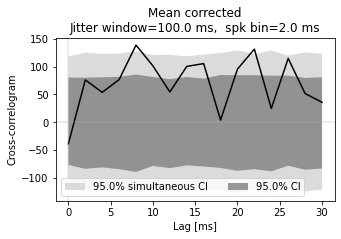

0.009
100%|███████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.42it/s]


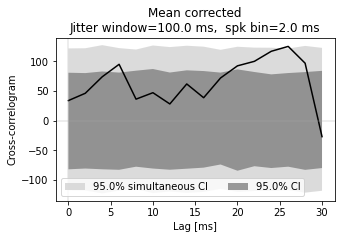

0.021
100%|███████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 66.71it/s]


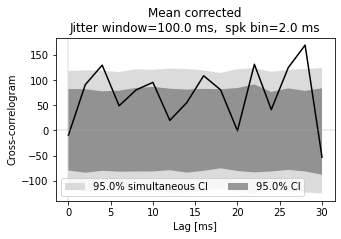

0.0
100%|█████████████████████████████████████████████████████████████████| 3/3 [00:45<00:00, 15.24s/it]


In [83]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_jitter/'

# model_name = 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma100ms_trials200_nonrepeated'
# save_name = 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma_100ms_trials10_nonrepeated'

model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
save_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_trials10_nonrepeated'

# model_name = 'poisson_background_gaussian_mixture_square_alphaN2_beta30ms_sigma100ms_trials200_nonrepeated'
# save_name = 'poisson_background_gaussian_mixture_square_alphaN2_beta30ms_sigma_100ms_trials10_nonrepeated'

# model_name = 'poisson_background_gaussian_mixture_square_alpha1_beta30ms_sigma100ms_trials10_nonrepeated'
# save_name = 'poisson_background_gaussian_mixture_square_alpha1_beta30ms_sigma_100ms_trials10_nonrepeated'

file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

num_selected_trials = 100
num_itrs = 3
spk_bin_width = 0.002
lag_range = [0, 0.03]
jitter_window_width = 100  # ms
distribution_type='mc_sim'
num_jitter = 1000

model_par_list = []
trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
for itr in trange:
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)
    spike_times_x, spike_times_y = spike_times[1], spike_times[0]
    ret_vals = jittertool.cross_correlation_jitter(
        spike_times_x[:num_selected_trials], spike_times_y[:num_selected_trials], spk_bin_width, trial_length,
        lag_range, jitter_window_width/1000, distribution_type=distribution_type, num_jitter=num_jitter, 
        ci_alpha=0.05, verbose=1)
    model_par_list.append(ret_vals)
    print(ret_vals[-2])
#     print(ret_vals[-1])

# file_path = model_dir + f'{save_name}_jwindow{jitter_window_width}ms_model_par_list.pkl'
# util.save_variable(file_path, model_par_list)

### Unmatch filter length.

In [24]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
save_model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_fitbeta_20ms_sigma100ms_trials200_nonrepeated'
# save_model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_fitbeta_40ms_sigma100ms_trials200_nonrepeated'
filter_length = 0.02

file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
num_itrs = 100
# kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 125, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
kernel_widths = [12 ]

for kernel_width in kernel_widths:
    model_par_list = []
    if kernel_width == 'none':
        model_par = {'filter_type': 'square', 'filter_length': filter_length,
                     'append_nuisance': ['const'],
                     'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
    else:
        model_par = {'filter_type': 'square', 'filter_length': filter_length,
                     'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': kernel_width/1000,
                     'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

    trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
    for itr in trange:
        file_path = data_dir + f'{model_name}_itr{itr}.pkl'
        spike_times = util.load_variable(file_path, verbose=False)
        spike_times_x, spike_times_y = spike_times[1], spike_times[0]
        model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
                spike_times_x, spike_times_y, [0,trial_length], model_par)
        model_par_list.append(model_par_hat)

    file_path = model_dir + f'{save_model_name}_kernel{kernel_width}ms_model_par_list.pkl'
    util.save_variable(file_path, model_par_list)

100%|█████████████████████████████████████████████████████████████| 100/100 [09:04<00:00,  5.44s/it]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/poisson_background_gaussian_mixture_square_alpha2_beta30ms_fitbeta_20ms_sigma100ms_trials200_nonrepeated_kernel12ms_model_par_list.pkl


### B-spline fitting.

In [45]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
save_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline'
file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

num_itrs = 100
# kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 125, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, ]


for kernel_width in kernel_widths:
    model_par_list = []
    if kernel_width == 'none':
        model_par = {'filter_type': 'bspline', 'num_knots': 9, 'knot_space_par': 1,
                     'filter_length': generator_par['beta'][0][1]*1.5, 'num_tail_drop': 1,
                     'append_nuisance': ['const'],
                     'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
    else:
        model_par = {'filter_type': 'bspline', 'num_knots': 9, 'knot_space_par': 1,
                     'filter_length': generator_par['beta'][0][1]*1.5, 'num_tail_drop': 1,
                     'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': kernel_width/1000,
                     'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

    trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
    for itr in trange:
        file_path = data_dir + f'{model_name}_itr{itr}.pkl'
        spike_times = util.load_variable(file_path, verbose=False)
        spike_times_x, spike_times_y = spike_times[1], spike_times[0]
        model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
                spike_times_x, spike_times_y, [0,trial_length], model_par)
        model_par_list.append(model_par_hat)
#         jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, ylim=[-2, 4], file_path=None)
    file_path = model_dir + f'{save_name}_kernel{kernel_width}ms_model_par_list.pkl'
    util.save_variable(file_path, model_par_list)

100%|█████████████████████████████████████████████████████████████| 100/100 [14:22<00:00,  8.63s/it]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_kernel2ms_model_par_list.pkl
100%|█████████████████████████████████████████████████████████████| 100/100 [16:29<00:00,  9.89s/it]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_kernel5ms_model_par_list.pkl
100%|█████████████████████████████████████████████████████████████| 100/100 [16:19<00:00,  9.79s/it]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussia

### Multivariate regression, Hawkes.

In [ ]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/multivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/multivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
model_name = 'poisson_background_gaussian_mixture_multivariate_nodes6_sigma_100ms_trials200_nonrepeated'

file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

num_nodes = 6
num_itrs = 100
model_par_list = []

model_par_const = {'append_nuisance': ['const'], 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_square0 = {'filter_type': 'square', 'filter_length': 0.03, 'append_nuisance': [],
                     'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
for itr in trange:
    multi_model_par_hat = {}
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)

    for tgt_node in range(num_nodes):
        src_nodes = list(range(num_nodes)); src_nodes.remove(tgt_node)
        src_spikes = [[]] + [spike_times[n] for n in src_nodes]
        tgt_spikes = spike_times[tgt_node]
        model_par_nodes = [model_par_const] + [model_par_square0.copy() for n in range(len(src_nodes))]  # constant baseline + filters.
        multi_model_par_hat[tgt_node] = jittertool.multivariate_continuous_time_coupling_filter_regression(src_spikes, tgt_spikes, trial_window, model_par_nodes)    

    model_par_list.append(multi_model_par_hat)

file_path = model_dir + f'{model_name}_hawkes_model_par_list.pkl'
util.save_variable(file_path, model_par_list)

### Multivariate regression pairwise.

In [20]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/multivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/multivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
model_name = 'poisson_background_gaussian_mixture_multivariate_nodes6_sigma_100ms_trials200_nonrepeated'

file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

num_nodes = 6
num_itrs = 100
model_par_list = []

model_par_const = {'append_nuisance': ['const'], 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_square0 = {'filter_type': 'square', 'filter_length': 0.03, 'append_nuisance': [],
                     'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
for itr in trange:
    multi_model_par_hat = {}
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)

    nodes = list(range(num_nodes))
    for src, tgt in itertools.permutations(nodes, 2):
        model_par_square = {'filter_type': 'square', 'filter_length': 0.03,
                     'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.13,
                     'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
        spike_times_x = spike_times[src]
        spike_times_y = spike_times[tgt]
        multi_model_par_hat[(src, tgt)] = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, trial_window, model_par_square)

    model_par_list.append(multi_model_par_hat)

file_path = model_dir + f'{model_name}_pairwise_model_par_list.pkl'
util.save_variable(file_path, model_par_list)

100%|██████████████████████████████████████████████████████████| 100/100 [3:02:34<00:00, 109.54s/it]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/multivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/poisson_background_gaussian_mixture_multivariate_nodes6_sigma_100ms_trials200_nonrepeated_pairwise_model_par_list.pkl


### Full model, bivarite.

##### Hawkes

In [16]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'

model_name = 'poisson_background_gaussian_mixture_square_full_model_beta30ms_sigma100ms_trials200_nonrepeated'

file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

num_itrs = 100
model_par = {'filter_type': 'square', 'filter_length': 0.03, 'self_filter_type': 'square', 'self_filter_length': 0.03,
             'append_nuisance': ['const'],
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

model_par_list = []
trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
for itr in trange:
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)
    spike_times_x, spike_times_y = spike_times[1], spike_times[0]
    model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_full_regression(
            spike_times_x, spike_times_y, [0,trial_length], model_par)
    model_par_list.append(model_par_hat)

file_path = model_dir + f'{model_name}_hawkes_x2y_model_par_list.pkl'
util.save_variable(file_path, model_par_list)

model_par_list = []
trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
for itr in trange:
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)
    spike_times_x, spike_times_y = spike_times[1], spike_times[0]
    model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_full_regression(
            spike_times_y, spike_times_x, [0,trial_length], model_par)
    model_par_list.append(model_par_hat)

file_path = model_dir + f'{model_name}_hawkes_y2x_model_par_list.pkl'
util.save_variable(file_path, model_par_list)

100%|█████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/poisson_background_gaussian_mixture_square_full_model_beta30ms_sigma100ms_trials200_nonrepeated_hawkes_x2y_model_par_list.pkl
100%|█████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/poisson_background_gaussian_mixture_square_full_model_beta30ms_sigma100ms_trials200_nonrepeated_hawkes_y2x_model_par_list.pkl


##### Jitter regression.

100%|███████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.31s/it]
optimal kernel width  90.0


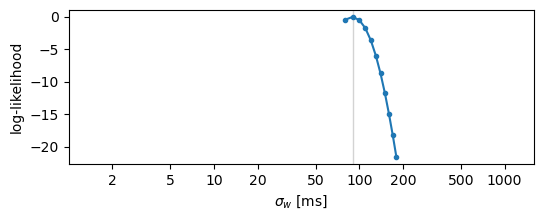

100%|███████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.34s/it]
optimal kernel width  110.0


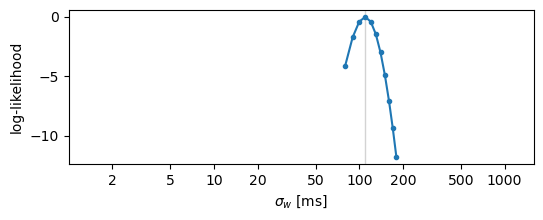

100%|███████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.32s/it]
optimal kernel width  90.0


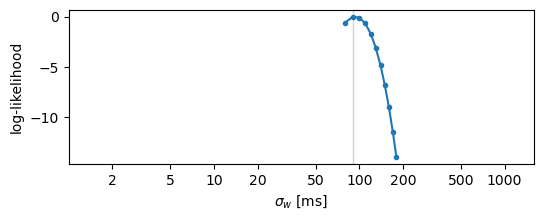

100%|███████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.28s/it]
optimal kernel width  100.0


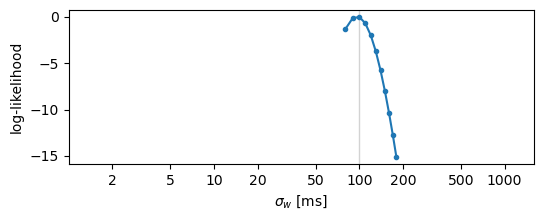

100%|███████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.34s/it]
optimal kernel width  110.0


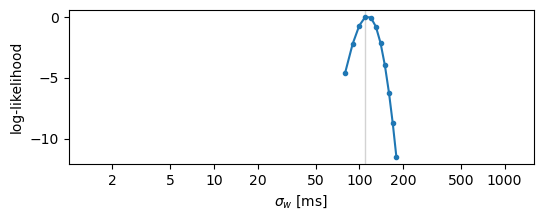

100%|███████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.31s/it]
optimal kernel width  110.0


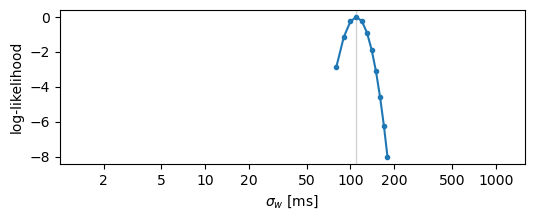

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.42s/it]
optimal kernel width  90.0


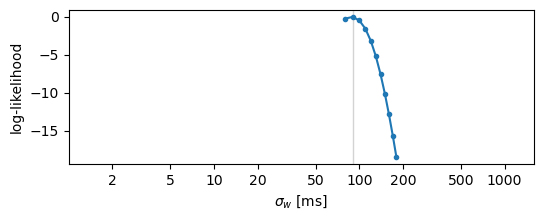

100%|███████████████████████████████████████████████████████████████| 11/11 [00:17<00:00,  1.59s/it]
optimal kernel width  100.0


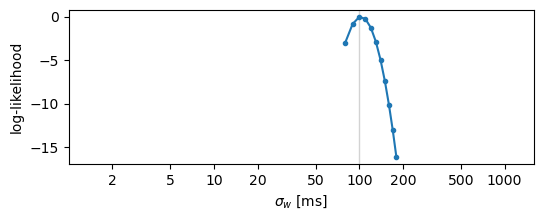

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.41s/it]
optimal kernel width  90.0


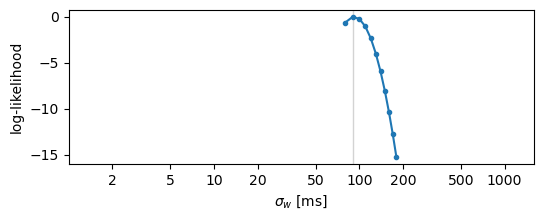

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.46s/it]
optimal kernel width  80.0


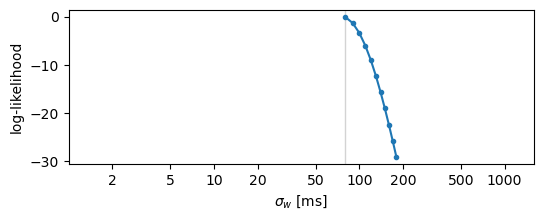

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.48s/it]
optimal kernel width  100.0


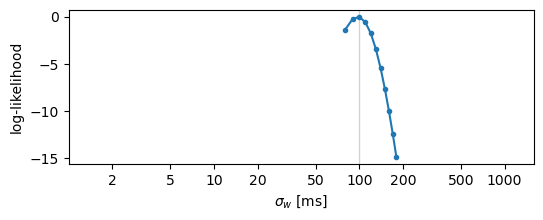

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.50s/it]
optimal kernel width  90.0


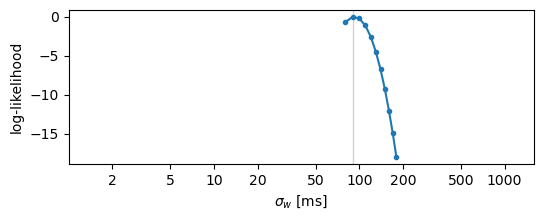

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.48s/it]
optimal kernel width  110.0


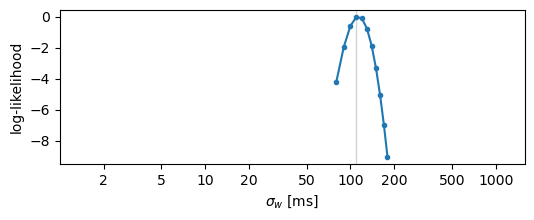

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.51s/it]
optimal kernel width  100.0


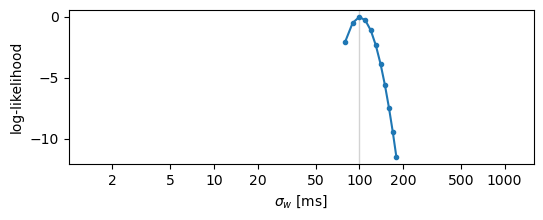

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  100.0


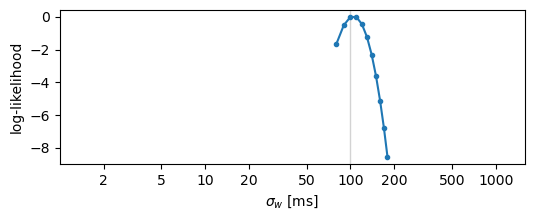

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  110.0


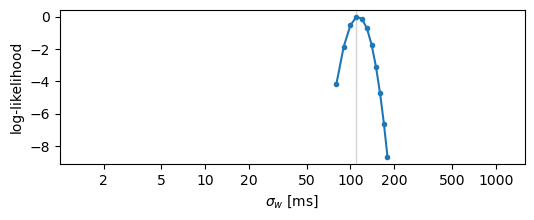

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.48s/it]
optimal kernel width  90.0


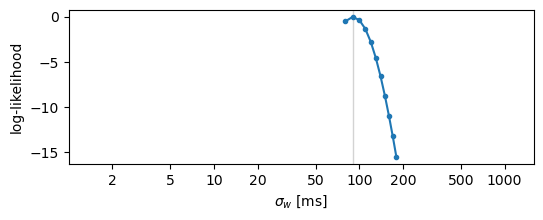

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.50s/it]
optimal kernel width  120.0


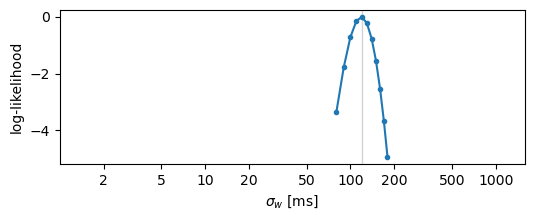

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  80.0


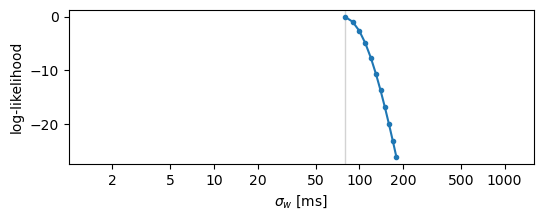

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  80.0


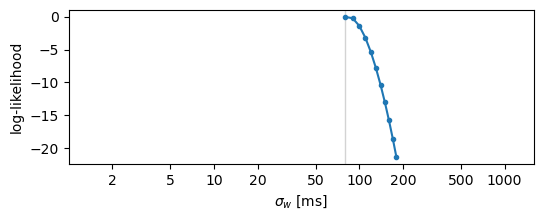

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.48s/it]
optimal kernel width  100.0


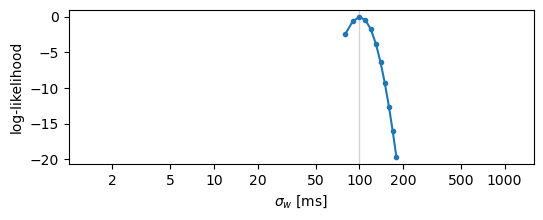

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.44s/it]
optimal kernel width  110.0


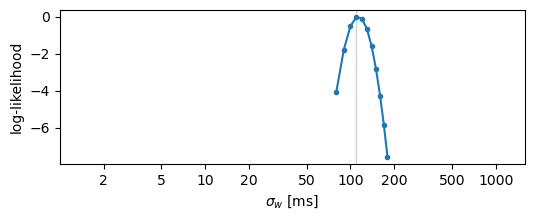

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.48s/it]
optimal kernel width  80.0


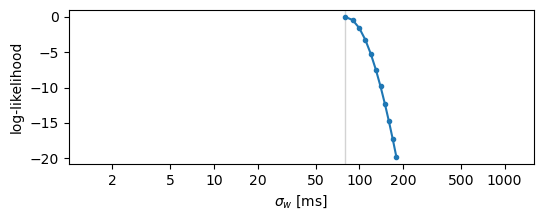

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.48s/it]
optimal kernel width  110.0


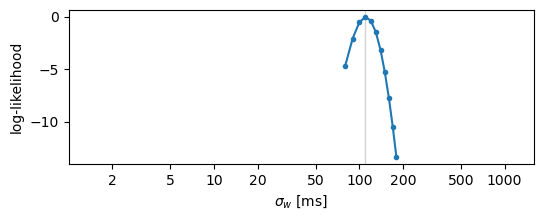

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.48s/it]
optimal kernel width  90.0


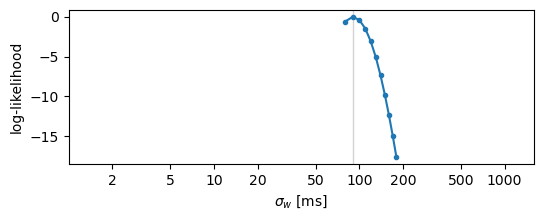

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.45s/it]
optimal kernel width  120.0


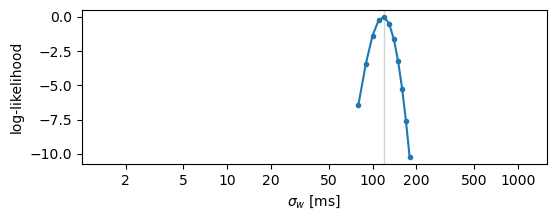

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.50s/it]
optimal kernel width  80.0


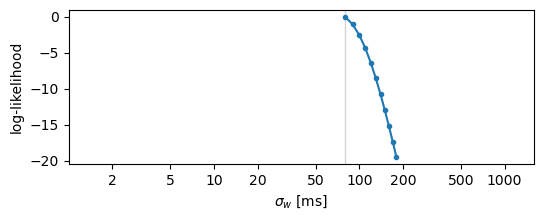

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  110.0


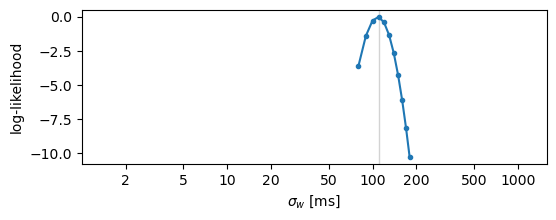

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  80.0


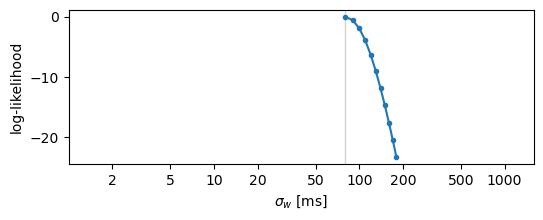

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.47s/it]
optimal kernel width  150.0


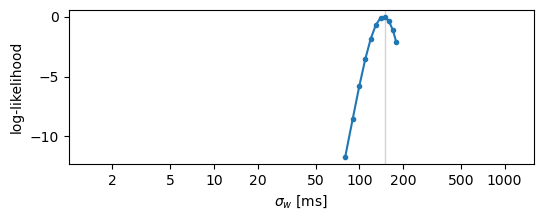

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  110.0


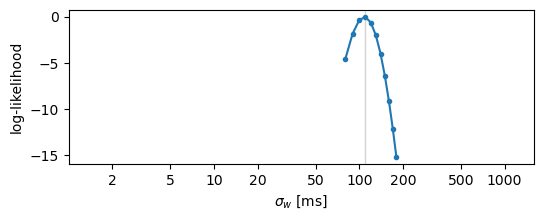

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.45s/it]
optimal kernel width  100.0


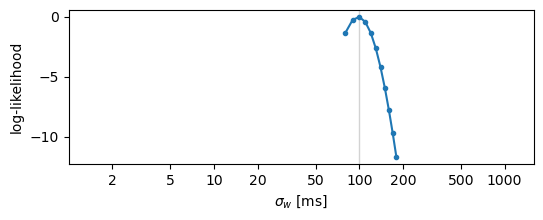

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  90.0


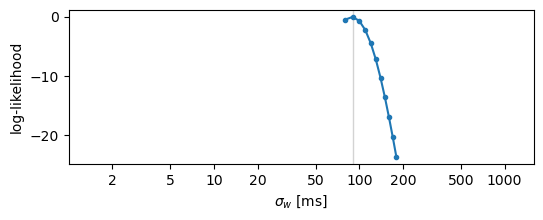

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.44s/it]
optimal kernel width  100.0


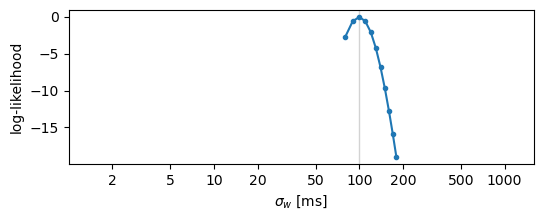

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  100.0


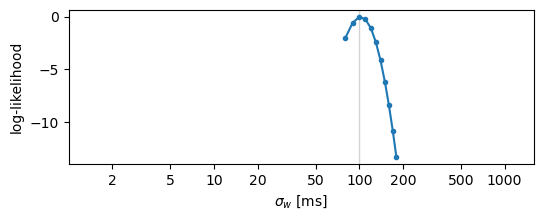

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.46s/it]
optimal kernel width  110.0


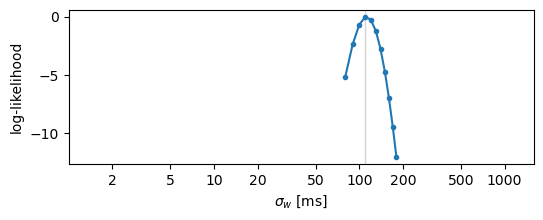

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.41s/it]
optimal kernel width  100.0


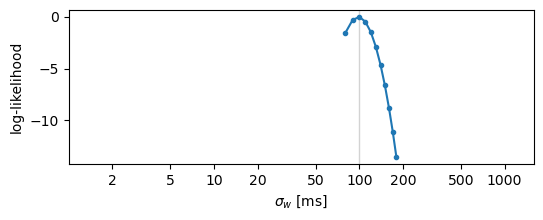

100%|███████████████████████████████████████████████████████████████| 11/11 [00:17<00:00,  1.59s/it]
optimal kernel width  90.0


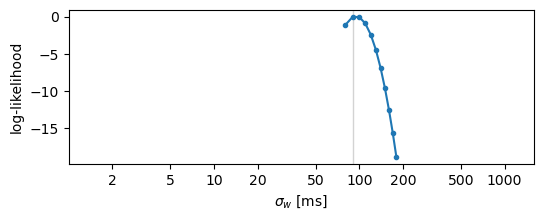

100%|███████████████████████████████████████████████████████████████| 11/11 [00:18<00:00,  1.68s/it]
optimal kernel width  100.0


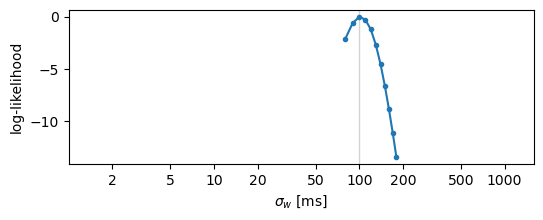

100%|███████████████████████████████████████████████████████████████| 11/11 [00:20<00:00,  1.83s/it]
optimal kernel width  100.0


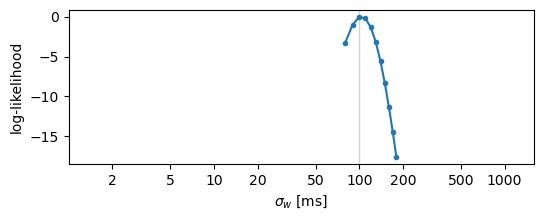

100%|███████████████████████████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]
optimal kernel width  80.0


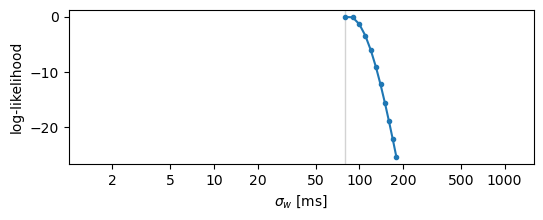

100%|███████████████████████████████████████████████████████████████| 11/11 [00:22<00:00,  2.08s/it]
optimal kernel width  80.0


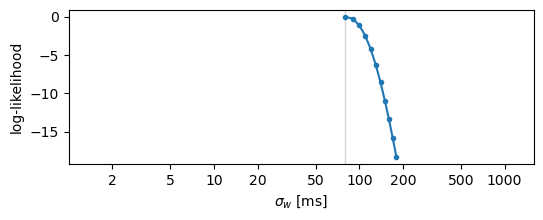

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.45s/it]
optimal kernel width  120.0


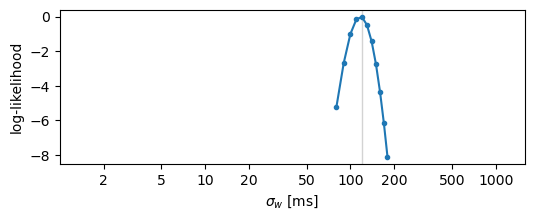

100%|███████████████████████████████████████████████████████████████| 11/11 [00:19<00:00,  1.73s/it]
optimal kernel width  100.0


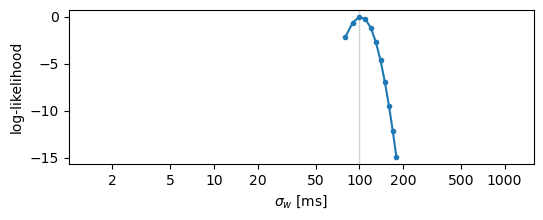

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.48s/it]
optimal kernel width  100.0


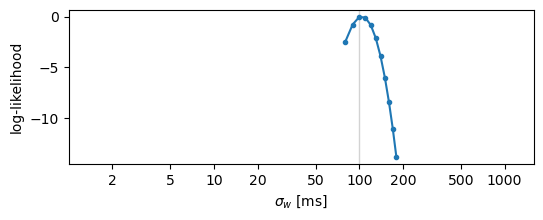

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  90.0


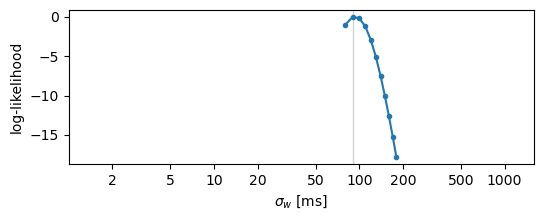

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.51s/it]
optimal kernel width  90.0


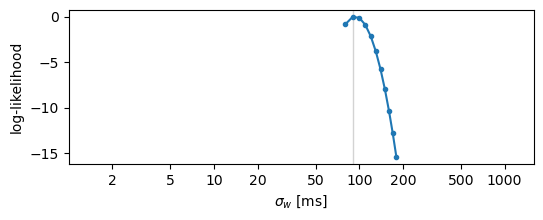

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  100.0


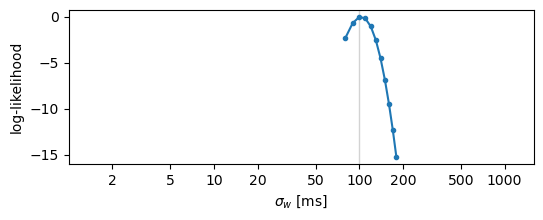

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.51s/it]
optimal kernel width  90.0


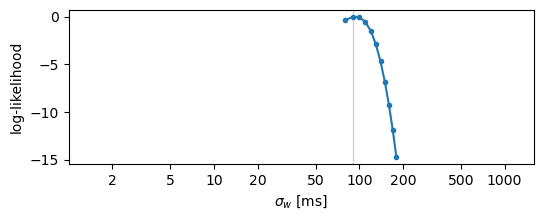

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  80.0


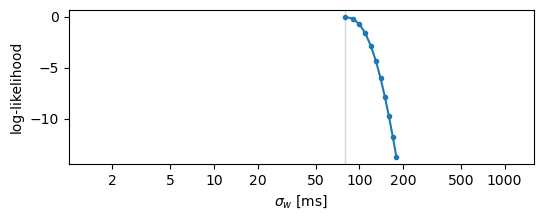

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.53s/it]
optimal kernel width  90.0


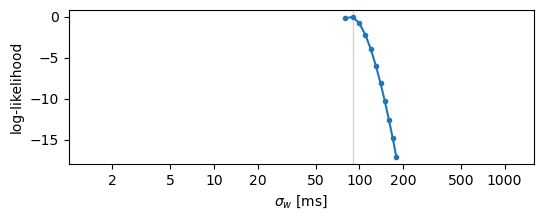

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  100.0


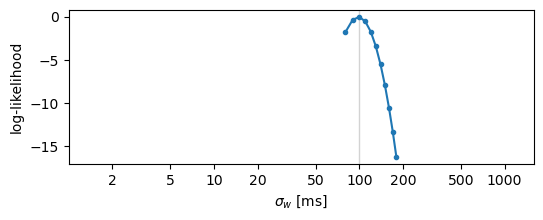

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  100.0


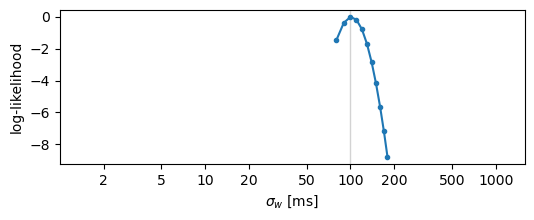

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.51s/it]
optimal kernel width  110.0


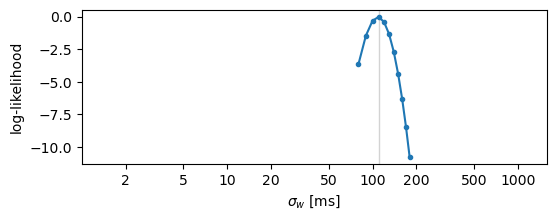

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  90.0


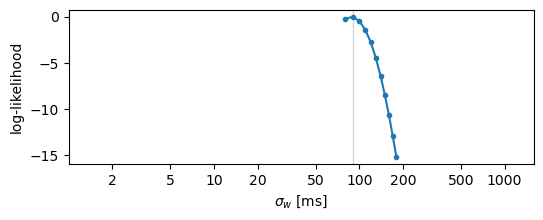

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.54s/it]
optimal kernel width  90.0


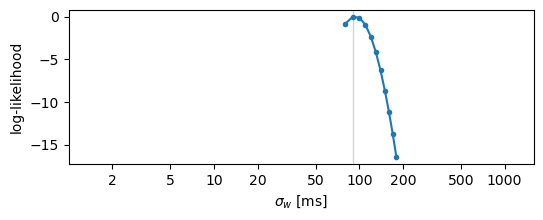

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.50s/it]
optimal kernel width  80.0


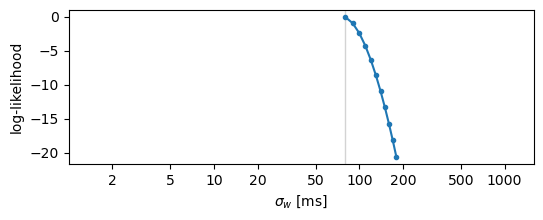

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.48s/it]
optimal kernel width  100.0


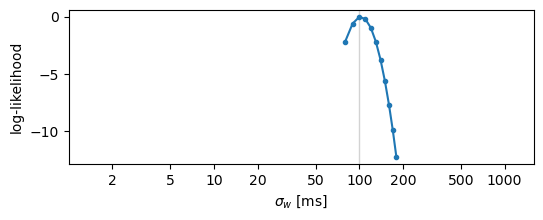

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  140.0


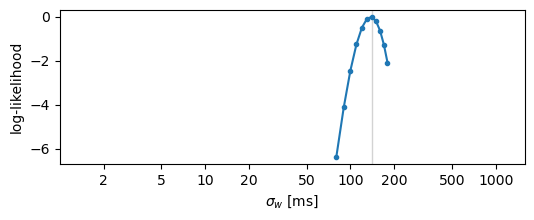

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  100.0


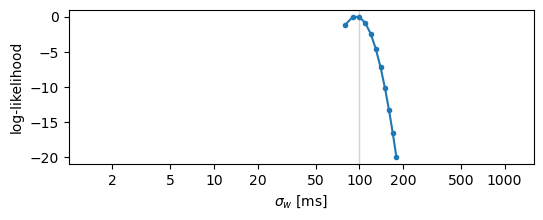

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  100.0


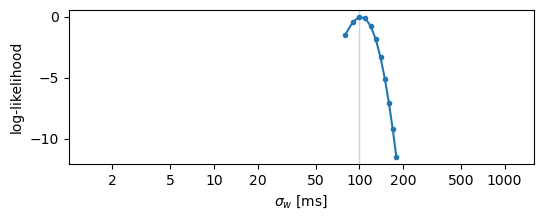

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.48s/it]
optimal kernel width  100.0


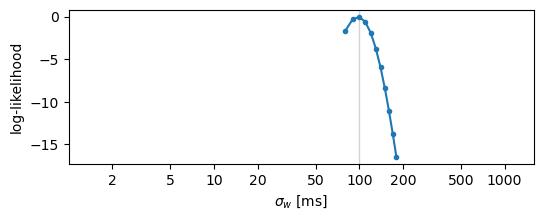

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.47s/it]
optimal kernel width  90.0


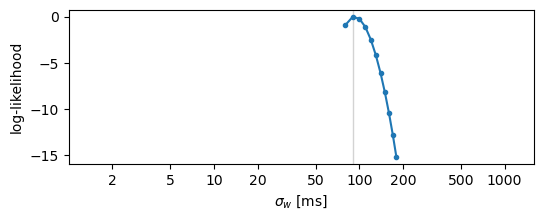

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.54s/it]
optimal kernel width  90.0


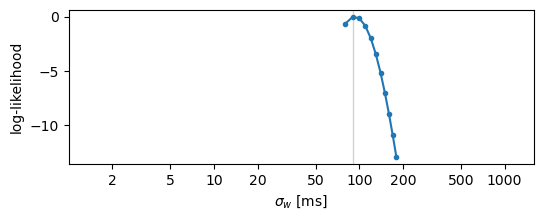

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  80.0


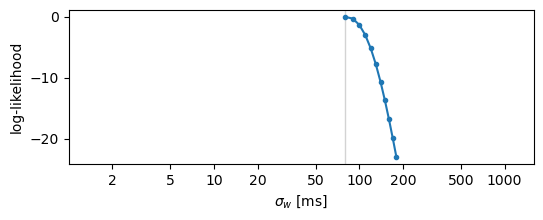

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  90.0


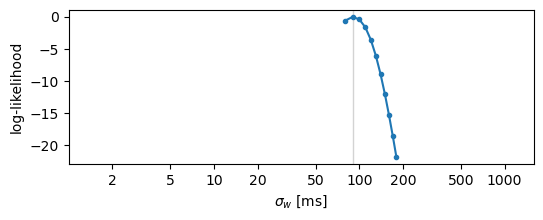

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  100.0


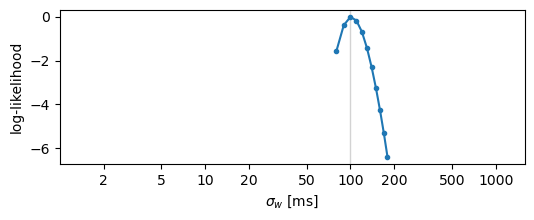

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.47s/it]
optimal kernel width  80.0


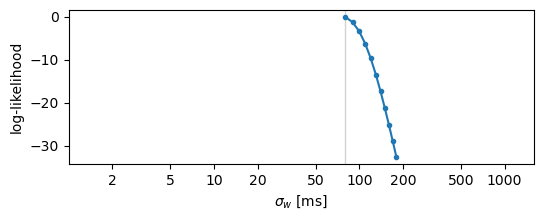

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  90.0


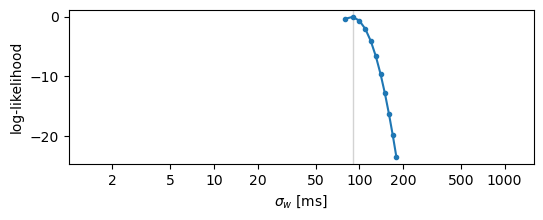

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.47s/it]
optimal kernel width  90.0


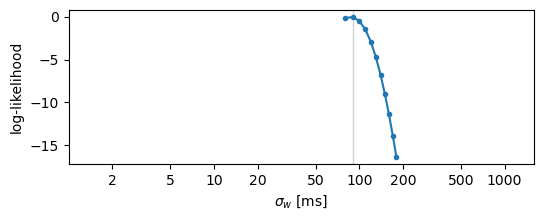

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.46s/it]
optimal kernel width  100.0


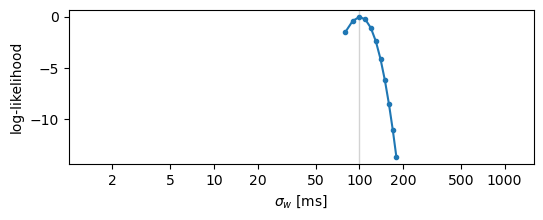

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.50s/it]
optimal kernel width  110.0


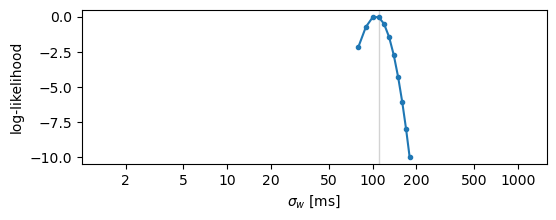

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  80.0


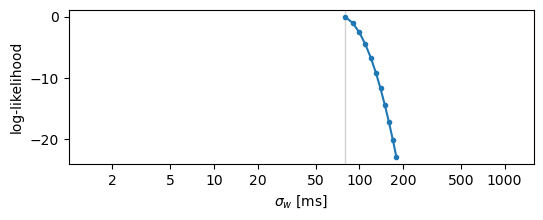

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.50s/it]
optimal kernel width  90.0


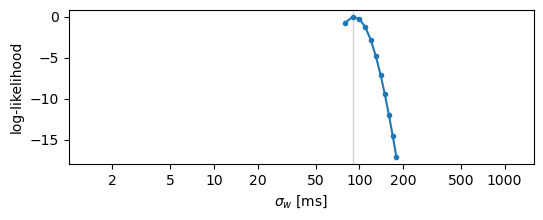

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.42s/it]
optimal kernel width  80.0


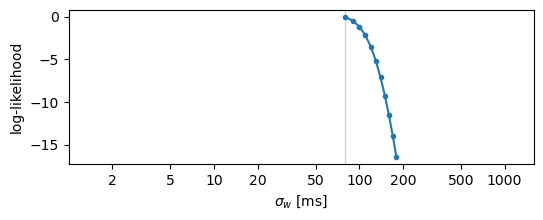

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.39s/it]
optimal kernel width  90.0


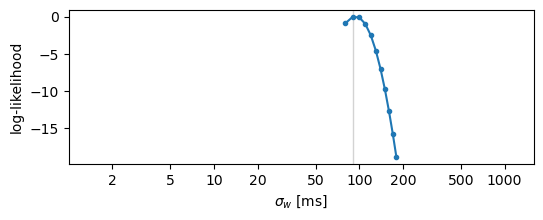

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.42s/it]
optimal kernel width  100.0


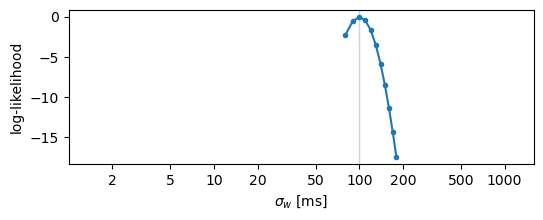

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.44s/it]
optimal kernel width  120.0


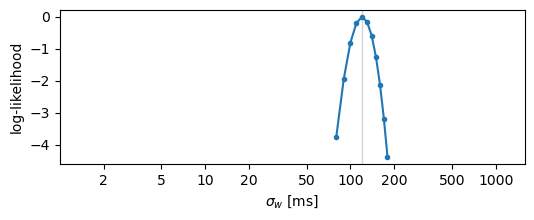

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.42s/it]
optimal kernel width  90.0


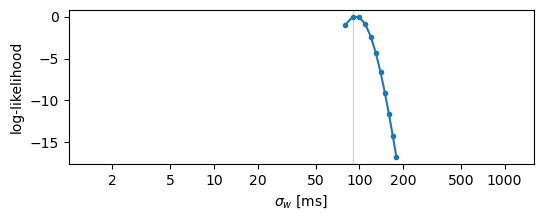

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.42s/it]
optimal kernel width  80.0


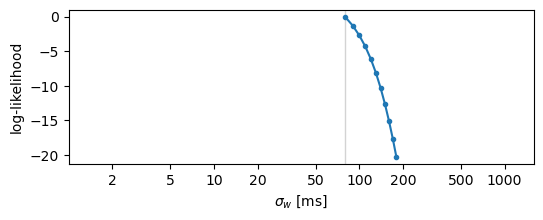

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.46s/it]
optimal kernel width  80.0


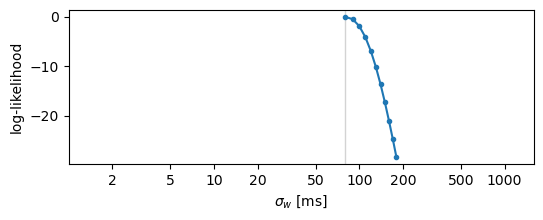

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.43s/it]
optimal kernel width  120.0


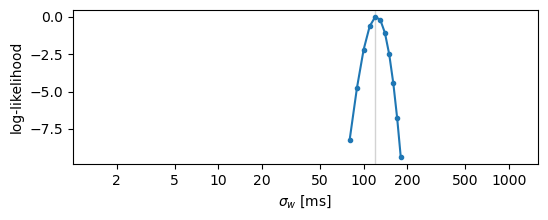

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.41s/it]
optimal kernel width  100.0


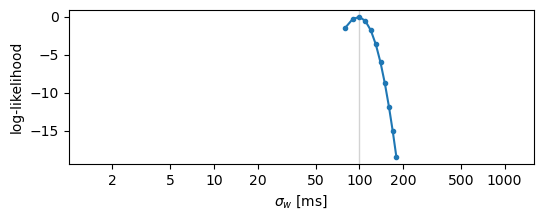

100%|███████████████████████████████████████████████████████████████| 11/11 [00:17<00:00,  1.60s/it]
optimal kernel width  80.0


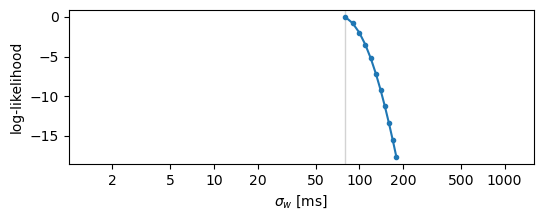

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.47s/it]
optimal kernel width  80.0


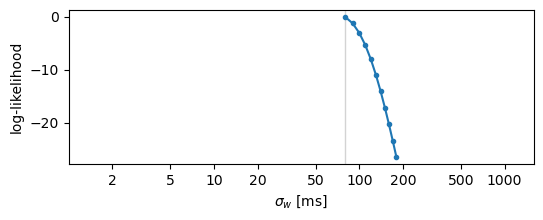

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  90.0


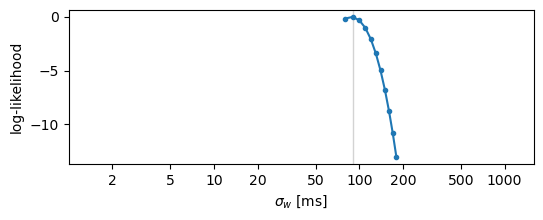

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.54s/it]
optimal kernel width  100.0


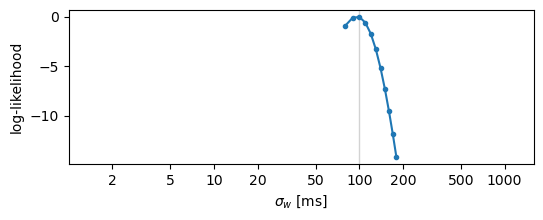

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.43s/it]
optimal kernel width  130.0


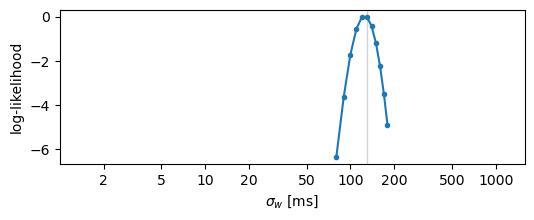

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.40s/it]
optimal kernel width  80.0


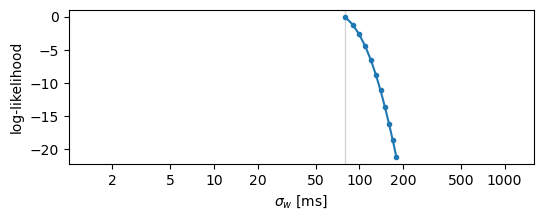

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.41s/it]
optimal kernel width  90.0


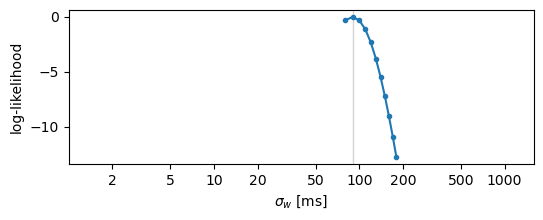

100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.44s/it]
optimal kernel width  90.0


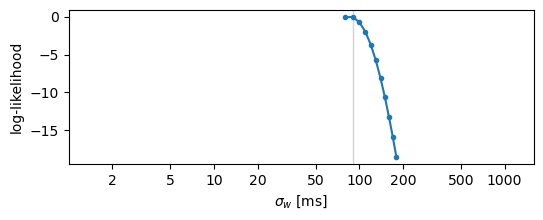

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.54s/it]
optimal kernel width  100.0


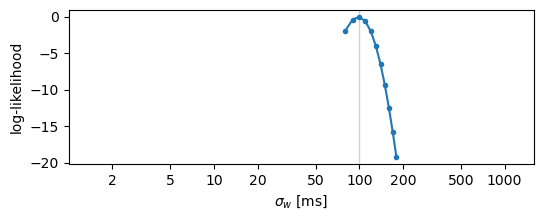

100%|███████████████████████████████████████████████████████████████| 11/11 [00:18<00:00,  1.68s/it]
optimal kernel width  110.0


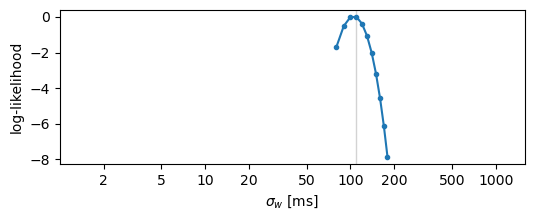

100%|███████████████████████████████████████████████████████████████| 11/11 [00:17<00:00,  1.58s/it]
optimal kernel width  100.0


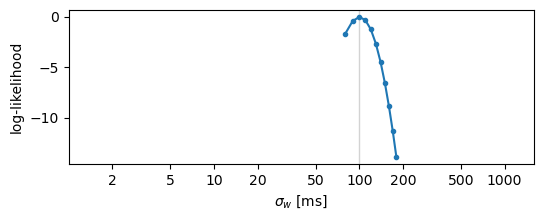

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]
optimal kernel width  110.0


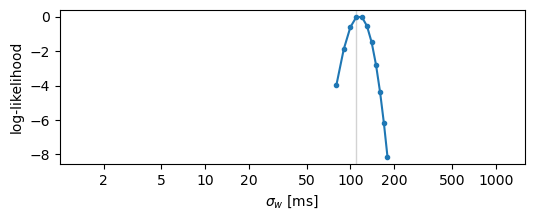

100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.49s/it]
optimal kernel width  140.0


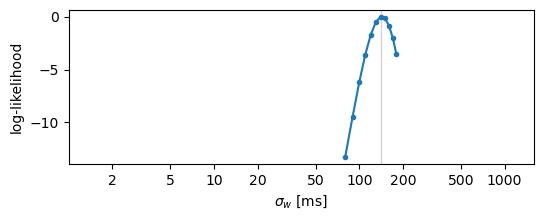

100%|███████████████████████████████████████████████████████████████| 11/11 [00:19<00:00,  1.75s/it]
optimal kernel width  90.0


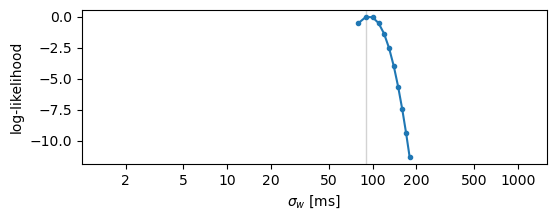

100%|███████████████████████████████████████████████████████████████| 11/11 [00:20<00:00,  1.90s/it]
optimal kernel width  100.0


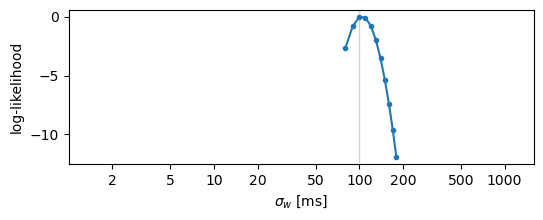

100%|███████████████████████████████████████████████████████████████| 11/11 [00:19<00:00,  1.75s/it]
optimal kernel width  80.0


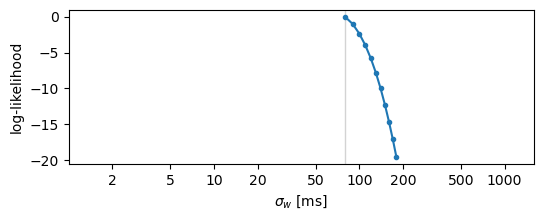

100%|███████████████████████████████████████████████████████████████| 11/11 [00:18<00:00,  1.72s/it]
optimal kernel width  90.0


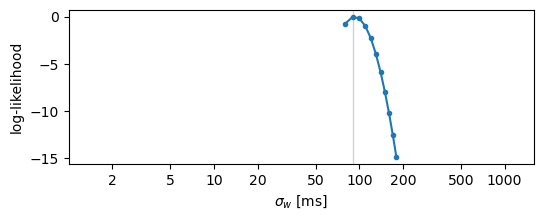

100%|█████████████████████████████████████████████████████████████| 100/100 [37:17<00:00, 22.37s/it]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/poisson_background_gaussian_mixture_square_full_model_beta30ms_sigma100ms_trials200_nonrepeated_x2y_kernel90.0ms_model_par_list.pkl


In [14]:
# x --> y
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'

model_name = 'poisson_background_gaussian_mixture_square_full_model_beta30ms_sigma100ms_trials200_nonrepeated'

file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
num_itrs = 100

model_par_list = []
trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
for itr in trange:
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)
    spike_times_x, spike_times_y = spike_times[1], spike_times[0]
    
    kernel_widths = np.arange(80, 190, 10) / 1000
    model_par = {'trial_window': trial_window, 'filter_type': 'square', 'filter_length': 0.03, 'self_filter_type': 'square', 'self_filter_length': 0.03, 
                 'append_nuisance': ['const', 'gaussian_kernel']}
    _,_,opt_kernel=jittertool.estimate_optimal_jitter_window_width_full_regression(spike_times_x[:50], spike_times_y[:50], model_par, kernel_width_grid=kernel_widths)
    
    model_par = {'filter_type': 'square', 'filter_length': 0.03, 'self_filter_type': 'square', 'self_filter_length': 0.03, 
                 'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': opt_kernel,
                 'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

    model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_full_regression(
            spike_times_x, spike_times_y, [0,trial_length], model_par)
    model_par_list.append(model_par_hat)

file_path = model_dir + f'{model_name}_x2y_model_par_list.pkl'
util.save_variable(file_path, model_par_list)

In [ ]:
# y --> x
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'

model_name = 'poisson_background_gaussian_mixture_square_full_model_beta30ms_sigma100ms_trials200_nonrepeated'

file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
num_itrs = 100

model_par_list = []
trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
for itr in trange:
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)
    spike_times_x, spike_times_y = spike_times[1], spike_times[0]
    
    kernel_widths = np.arange(80, 190, 10) / 1000
    model_par = {'trial_window': trial_window, 'filter_type': 'square', 'filter_length': 0.03, 'self_filter_type': 'square', 'self_filter_length': 0.03, 
                 'append_nuisance': ['const', 'gaussian_kernel']}
    _,_,opt_kernel=jittertool.estimate_optimal_jitter_window_width_full_regression(spike_times_y[:50], spike_times_x[:50], model_par, kernel_width_grid=kernel_widths)
    
    model_par = {'filter_type': 'square', 'filter_length': 0.03, 'self_filter_type': 'square', 'self_filter_length': 0.03, 
                 'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': opt_kernel,
                 'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

    model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_full_regression(
            spike_times_y, spike_times_x, [0,trial_length], model_par)
    model_par_list.append(model_par_hat)

file_path = model_dir + f'{model_name}_y2x_kernel{opt_kernel*1000}ms_model_par_list.pkl'
util.save_variable(file_path, model_par_list)